In [215]:
import numpy as np
import matplotlib.pyplot as plt
import math

def generate_points_within_cell(cell_x, cell_y, totalPoints):
    """
    Generate points within a 1x1 cell arranged in a grid pattern.

    Parameters:
    - cell_x, cell_y: Coordinates of the bottom-left corner of the cell.
    - num_points_per_side: Number of points along each side of the grid (default is 3 for 3x3).
    - padding: Space from the cell borders to the outermost points.

    Returns:
    - List of (x, y) tuples representing point coordinates.
    """
    padding=0.25
    num_points_per_side = max(2, math.ceil(np.sqrt(totalPoints)))
    drawnPoints = 0

    points = []
    spacing = (1 - 2 * padding) / (num_points_per_side - 1)
    for i in range(num_points_per_side):
        for j in range(num_points_per_side):
            x = cell_x + padding + j * spacing
            y = cell_y + padding + i * spacing
            points.append((x, y))

            drawnPoints += 1
            if drawnPoints >= totalPoints:
                break
        if drawnPoints >= totalPoints:
            break
    return points

def collectAllPoints(area):
# Collect all points from the grid
    all_points = []
    all_temperatures = []

    for row in area:
        for cell in row:
            cell_points = generate_points_within_cell(cell.x, cell.y, len(cell.particles))
            all_points.extend(cell_points)
            all_temperatures.extend(map(lambda c: c.temp, cell.particles))

    # Separate x and y coordinates for plotting
    x_coords, y_coords = zip(*all_points)

    return x_coords, y_coords, all_temperatures

def getCellText(cell):
    return f'T:{math.floor(cell.getTemp())} D:{len(cell.particles)}'


def drawPlot(area):
    x_coords, y_coords, all_temperatures = collectAllPoints(area)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the 1x1 grid cells as squares
    for i in range(len(area)):
        for j in range(len(area[i])):
            square = plt.Rectangle((i, j), 1, 1, edgecolor='black', facecolor='none', linewidth=0.5)
            ax.add_patch(square)
            ax.text(i+0.5, j+0.5, getCellText(area[len(area[i])-1-j][i]), ha='center', va='center', fontsize=6, color='black')

    # Create a scatter plot with temperature-based colors
    scatter = ax.scatter(x_coords, y_coords, c=all_temperatures, cmap='coolwarm', vmin=15, vmax=30, s=50)

    # plt.clim(15,30)

    # Add a color bar to show temperature scale
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Temperature (°C)')

    # Set axis limits
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)

    # Set labels and title
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    # ax.set_title('2D Grid with 9 Points per Cell Colored by Temperature')

    # Set aspect of the plot to be equal
    ax.set_aspect('equal')

    # Show the plot
    plt.show()

In [216]:
class Particle:
    def __init__(self, temp):
        self.temp = temp
        self.state = 'liquid'

class Spatial2dArea:
    def __init__(self, x, y, temp, numParticles):
        self.x = x
        self.y = y
        self.particles = [Particle(temp) for i in range(numParticles)]

    def __str__(self):
        return f"[({self.x}, {self.y}), Particles: {len(self.particles)})]"

    def removeLastParticle(self):
        return self.particles.pop()

    def removeNParticles(self, n):
        if n > len(self.particles):
            raise ValueError("Cannot remove more particles than available.")
        return [self.particles.pop() for i in range(n)]

    def heatUpParticles(self, inc):
        for i in self.particles:
            i.temp += inc
        return self.particles

    # Adding particles to another cell averages out the temp to simulate heat transfer
    def extendParticles(self, particles):
        self.particles.extend(particles)
        avgTemp = sum(map(lambda p: p.temp, self.particles)) / len(self.particles)

        for i in self.particles:
            i.temp = avgTemp

        return avgTemp

    def getTemp(self):
        if len(self.particles) == 0:
            raise ValueError("No particles exist in this cell.")
        return self.particles[0].temp


def getWaterLevel(areaList):
    return areaList[-1]

def printAreaRow(areaRow):
    line = ''
    for i in areaRow:
        line += str(i) + ' '
    print(line)

def printFullAreaList(areaList):
    for row in areaList:
        printAreaRow(row)

# bottom left is 0,0 - top right is 9,9
def initializeAreaGrid():
    return [[Spatial2dArea(i, j, 24-j, 30-j*2) for i in range(9+1)] for j in range(9, -1, -1)]

def heatUpWater(area, increment):
    waterLevel = getWaterLevel(area)
    for i in waterLevel:
        i.temp += increment
        for j in i.particles:
            j.temp += increment
    return area

def createLowPressureZone(area, lowerXBound, upperXBound, numParticles):
    for i in range(0, len(area)-1):
        row = area[i]
        spatialSlice = row[lowerXBound:upperXBound+1]

        for cell in spatialSlice:
            cell.particles = [Particle(cell.temp) for _ in range(numParticles+i)]

    return area

def heatMiddleOfWater(area, increment):
    for cell in areaGrid[-1][4:6]:
        cell.heatUpParticles(increment)

    return area


In [217]:
'''
water evaporation depends on:
- temp diff
- pressure - normal pressure @ water is 210 with my current setup
'''

def getYIdx(area, y, *args):
    yArgs = [y]
    yArgs.extend(args)
    idx = []
    for i in yArgs:
        idx.append(len(area)-1-i)
    return idx

def evaporateParticles(area, x, y0, y1, numParticles):
    print(f'Evaporating from {x}, {y0} to {y1} with {numParticles} num')
    y0Idx, y1Idx = getYIdx(area, y0, y1)

    evaporatingParticles = area[y0Idx][x].removeNParticles(numParticles)

    # adiabatic cooling to lose temp as air rises
    for i in evaporatingParticles:
        i.temp -= 1

    # temp gets avged out for heat transfer
    area[y1Idx][x].extendParticles(evaporatingParticles)

    return area

# assuming that every increase in altitude decreases temp by 1.
# if temp diff greater than 1
def getTempDiff(area, x, y0, y1):
    y0Idx, y1Idx = getYIdx(area, y0, y1)

    return area[y0Idx][x].getTemp() - area[y1Idx][x].getTemp() - 1

def getPressureDiff(area, x, y0, y1):
    y0Idx, y1Idx = getYIdx(area, y0, y1)

    # to do: if pressure in col is greater than normal
    # pressureInCell = len(area[y0Idx][x].particles)
    # pressureInCol = 0
    # for i in range(y0+1, len(area)):
    #     pressureInCol += len(i[i][x].particles)

    return len(area[y0Idx][x].particles) - len(area[y1Idx][x].particles)


# difference between temp + pressure of y
# threshold for evaportion is arbritary 3
# evaporating from y0 TO y1
def numParticlesEvaporating(area, x, y0, y1):
    tempDiff = math.floor(abs(getTempDiff(area, x, y0, y1)))
    pressureDiff = max(0, getPressureDiff(area, x, y0, y1))
    sumOfFactors = tempDiff + pressureDiff - 3
    numEvaporating = max(0, sumOfFactors)
    return numEvaporating


def handleEvaporation(area):
    for y in range(len(area)-1, 0, -1):
        for x in range(len(area[y])):
            print(f'x: {x}, y: {y-1} y1: {y} ')
            numParticles = numParticlesEvaporating(area, x, y-1, y)
            print(f'x: {x}, y: {y-1} y1: {y} numParticles: {numParticles}')
            if numParticles > 0:
                area = evaporateParticles(area, x, y-1, y, numParticles)
    return area

[(0, 9), Particles: 12)] [(1, 9), Particles: 12)] [(2, 9), Particles: 12)] [(3, 9), Particles: 12)] [(4, 9), Particles: 12)] [(5, 9), Particles: 12)] [(6, 9), Particles: 12)] [(7, 9), Particles: 12)] [(8, 9), Particles: 12)] [(9, 9), Particles: 12)] 
[(0, 8), Particles: 14)] [(1, 8), Particles: 14)] [(2, 8), Particles: 14)] [(3, 8), Particles: 14)] [(4, 8), Particles: 14)] [(5, 8), Particles: 14)] [(6, 8), Particles: 14)] [(7, 8), Particles: 14)] [(8, 8), Particles: 14)] [(9, 8), Particles: 14)] 
[(0, 7), Particles: 16)] [(1, 7), Particles: 16)] [(2, 7), Particles: 16)] [(3, 7), Particles: 16)] [(4, 7), Particles: 16)] [(5, 7), Particles: 16)] [(6, 7), Particles: 16)] [(7, 7), Particles: 16)] [(8, 7), Particles: 16)] [(9, 7), Particles: 16)] 
[(0, 6), Particles: 18)] [(1, 6), Particles: 18)] [(2, 6), Particles: 18)] [(3, 6), Particles: 18)] [(4, 6), Particles: 18)] [(5, 6), Particles: 18)] [(6, 6), Particles: 18)] [(7, 6), Particles: 18)] [(8, 6), Particles: 18)] [(9, 6), Particles: 18

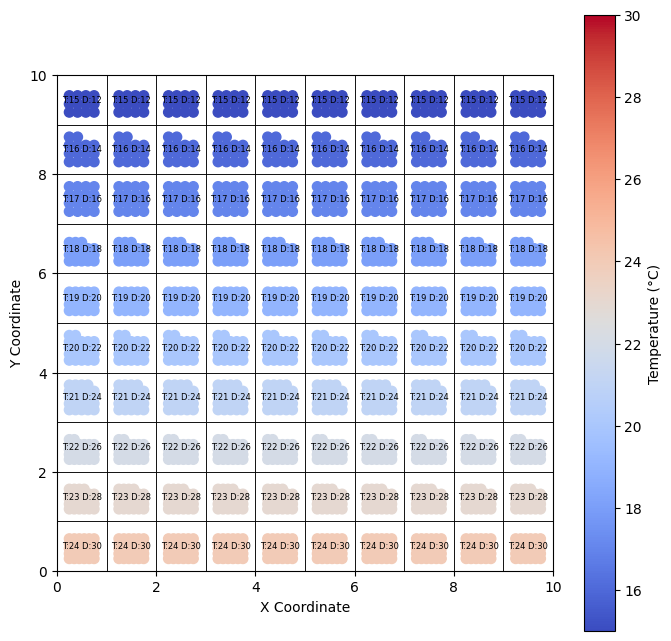

In [218]:
areaGrid = initializeAreaGrid()
printFullAreaList(areaGrid)
drawPlot(areaGrid)

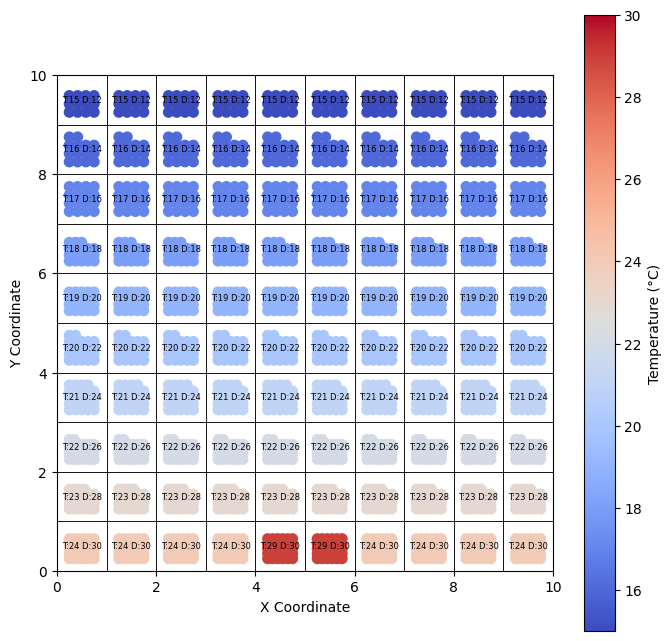

In [219]:
areaGrid = heatMiddleOfWater(areaGrid, 5)
drawPlot(areaGrid)

x: 0, y: 8 y1: 9 
x: 0, y: 8 y1: 9 numParticles: 0
x: 1, y: 8 y1: 9 
x: 1, y: 8 y1: 9 numParticles: 0
x: 2, y: 8 y1: 9 
x: 2, y: 8 y1: 9 numParticles: 0
x: 3, y: 8 y1: 9 
x: 3, y: 8 y1: 9 numParticles: 0
x: 4, y: 8 y1: 9 
x: 4, y: 8 y1: 9 numParticles: 0
x: 5, y: 8 y1: 9 
x: 5, y: 8 y1: 9 numParticles: 0
x: 6, y: 8 y1: 9 
x: 6, y: 8 y1: 9 numParticles: 0
x: 7, y: 8 y1: 9 
x: 7, y: 8 y1: 9 numParticles: 0
x: 8, y: 8 y1: 9 
x: 8, y: 8 y1: 9 numParticles: 0
x: 9, y: 8 y1: 9 
x: 9, y: 8 y1: 9 numParticles: 0
x: 0, y: 7 y1: 8 
x: 0, y: 7 y1: 8 numParticles: 0
x: 1, y: 7 y1: 8 
x: 1, y: 7 y1: 8 numParticles: 0
x: 2, y: 7 y1: 8 
x: 2, y: 7 y1: 8 numParticles: 0
x: 3, y: 7 y1: 8 
x: 3, y: 7 y1: 8 numParticles: 0
x: 4, y: 7 y1: 8 
x: 4, y: 7 y1: 8 numParticles: 0
x: 5, y: 7 y1: 8 
x: 5, y: 7 y1: 8 numParticles: 0
x: 6, y: 7 y1: 8 
x: 6, y: 7 y1: 8 numParticles: 0
x: 7, y: 7 y1: 8 
x: 7, y: 7 y1: 8 numParticles: 0
x: 8, y: 7 y1: 8 
x: 8, y: 7 y1: 8 numParticles: 0
x: 9, y: 7 y1: 8 
x: 9, y: 7 y1

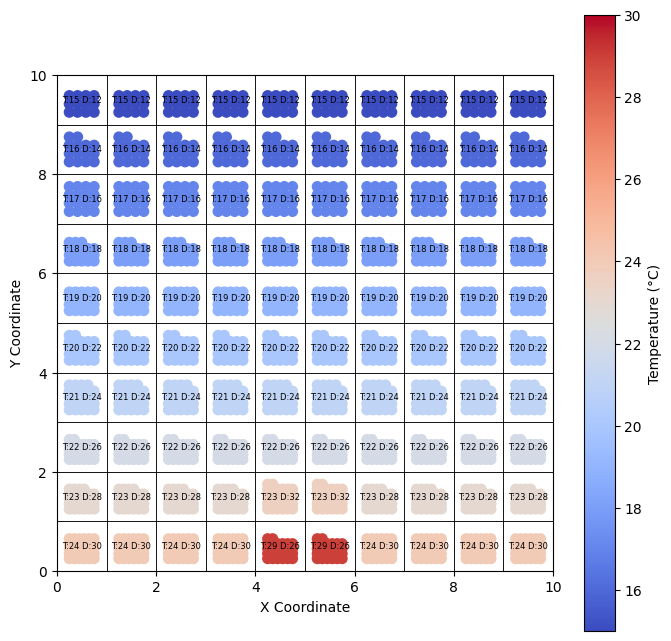

In [220]:
areaGrid = handleEvaporation(areaGrid)
drawPlot(areaGrid)

x: 0, y: 8 y1: 9 
x: 0, y: 8 y1: 9 numParticles: 0
x: 1, y: 8 y1: 9 
x: 1, y: 8 y1: 9 numParticles: 0
x: 2, y: 8 y1: 9 
x: 2, y: 8 y1: 9 numParticles: 0
x: 3, y: 8 y1: 9 
x: 3, y: 8 y1: 9 numParticles: 0
x: 4, y: 8 y1: 9 
x: 4, y: 8 y1: 9 numParticles: 0
x: 5, y: 8 y1: 9 
x: 5, y: 8 y1: 9 numParticles: 0
x: 6, y: 8 y1: 9 
x: 6, y: 8 y1: 9 numParticles: 0
x: 7, y: 8 y1: 9 
x: 7, y: 8 y1: 9 numParticles: 0
x: 8, y: 8 y1: 9 
x: 8, y: 8 y1: 9 numParticles: 0
x: 9, y: 8 y1: 9 
x: 9, y: 8 y1: 9 numParticles: 0
x: 0, y: 7 y1: 8 
x: 0, y: 7 y1: 8 numParticles: 0
x: 1, y: 7 y1: 8 
x: 1, y: 7 y1: 8 numParticles: 0
x: 2, y: 7 y1: 8 
x: 2, y: 7 y1: 8 numParticles: 0
x: 3, y: 7 y1: 8 
x: 3, y: 7 y1: 8 numParticles: 0
x: 4, y: 7 y1: 8 
x: 4, y: 7 y1: 8 numParticles: 0
x: 5, y: 7 y1: 8 
x: 5, y: 7 y1: 8 numParticles: 0
x: 6, y: 7 y1: 8 
x: 6, y: 7 y1: 8 numParticles: 0
x: 7, y: 7 y1: 8 
x: 7, y: 7 y1: 8 numParticles: 0
x: 8, y: 7 y1: 8 
x: 8, y: 7 y1: 8 numParticles: 0
x: 9, y: 7 y1: 8 
x: 9, y: 7 y1

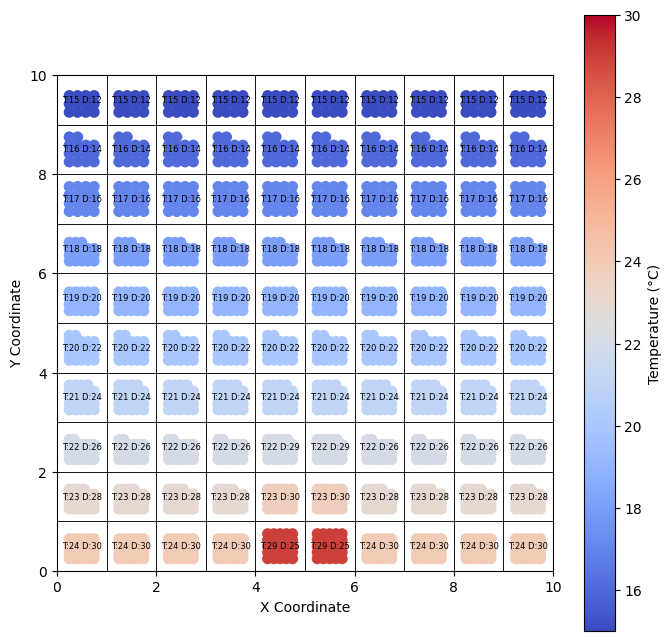

In [221]:
areaGrid = handleEvaporation(areaGrid)
drawPlot(areaGrid)

Critique: As the air rises, I'm showing the air moving to the cell above. When air rises, it displaces the air above it. The displaced air moves downwards or sideways.